In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import mpl, plt
from skimage import io

# best font and style settings for notebook 
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = 'MiSans'
# 生成一个随机数据集（正态分布）

In [6]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 路径设置
train_img_path = r"D:\IDMDownloads\ZIP\data\data_for_keras_aug\train_images\train"
train_mask_path = r"D:\IDMDownloads\ZIP\data\data_for_keras_aug\train_masks\train"

# 随机选择一张图片
file_list = os.listdir(train_img_path)
random_filename = random.choice(file_list)

# 拼接图片和 mask 的完整路径
img_file = os.path.join(train_img_path, random_filename)
mask_file = os.path.join(train_mask_path, random_filename)

# 读取图像和 mask
img = Image.open(img_file).convert('RGB')
mask = Image.open(mask_file).convert('L')  # 灰度模式加载

# 可视化
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title(f"Image: {random_filename}")
axs[0].axis('off')

axs[1].imshow(mask, cmap='gray')
axs[1].set_title(f"Mask: {random_filename}")
axs[1].axis('off')

plt.tight_layout()
plt.show()


❌ 没有找到图片和 mask 都存在的样本！请检查路径和文件名是否对应。


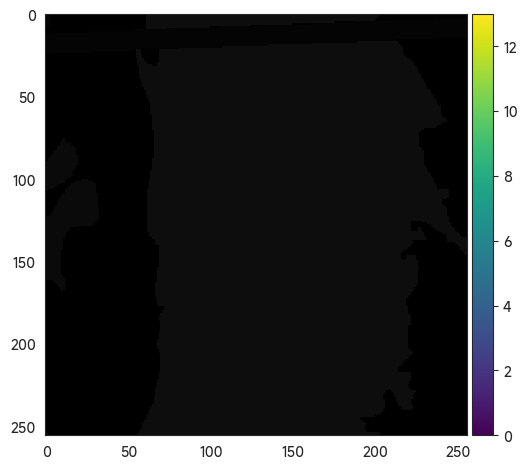

In [27]:
io.imshow(
    io.imread(r"D:\IDMDownloads\ZIP\data\data_for_keras_aug\train_images\train\GF2_PMS1__L1A0000564539-MSS1_06.tif")[0])
mask_np = \
    io.imread(
        r"D:\IDMDownloads\ZIP\data\data_for_keras_aug\train_masks\train\GF2_PMS1__L1A0000564539-MSS1_15label_06.tif")[
        0]
np.unique(mask_np)
io.imshow(mask_np)

In [61]:
import os
import random
from glob import glob


def build_dataset(image_dir, mask_dir):
    image_paths = glob(os.path.join(image_dir, '*.png'))
    pairs = []

    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        parts = img_name.split('_')
        if len(parts) >= 2:
            parts[-1] = '15label_' + parts[-1]
            mask_name = '_'.join(parts)
            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.exists(mask_path):
                pairs.append((img_path, mask_path))
            else:
                print(f"[⚠️] 掩膜不存在：{mask_path}")
    return pairs


def write_split_txt(pairs, save_dir, train_ratio=0.95):
    os.makedirs(save_dir, exist_ok=True)
    random.shuffle(pairs)

    split_idx = int(len(pairs) * train_ratio)
    train_pairs = pairs[:split_idx]
    val_pairs = pairs[split_idx:]

    train_txt = os.path.join(save_dir, 'train.txt')
    val_txt = os.path.join(save_dir, 'val.txt')

    with open(train_txt, 'w') as f:
        for img, mask in train_pairs:
            img = img.replace('..\\gid\\', '.\\')
            mask = mask.replace('..\\gid\\', '.\\')
            f.write(f"{img} {mask}\n")

    with open(val_txt, 'w') as f:
        for img, mask in val_pairs:
            img = img.replace('..\\gid\\', '.\\')
            mask = mask.replace('..\\gid\\', '.\\')
            f.write(f"{img} {mask}\n")

    print(f"[✅] train.txt 写入 {len(train_pairs)} 条")
    print(f"[✅] val.txt 写入 {len(val_pairs)} 条")


# 文件夹路径（请替换成你的）
image_dir = r"..\gid\train_images\train_png"
mask_dir = r"..\gid\train_masks\train_png"
save_dir = r"..\gid"  # 存放 train.txt、val.txt

# 执行
dataset_pairs = build_dataset(image_dir, mask_dir)
write_split_txt(dataset_pairs, save_dir)


[✅] train.txt 写入 33527 条
[✅] val.txt 写入 1765 条


In [59]:
import os
import numpy as np
import tifffile
from PIL import Image
from tqdm import tqdm

# 修改为你的文件夹路径
image_dir = r"..\gid\train_images\train"
mask_dir = r"..\gid\train_masks\train"

# 输出保存为 PNG 的文件夹
image_out_dir = image_dir + "_png"
mask_out_dir = mask_dir + "_png"

# 创建输出目录（如果不存在）
os.makedirs(image_out_dir, exist_ok=True)
os.makedirs(mask_out_dir, exist_ok=True)


def convert_tif_to_png(in_dir, out_dir, file_list):
    os.makedirs(out_dir, exist_ok=True)

    for tif_file in tqdm(file_list, desc=f"Processing {os.path.basename(in_dir)}"):
        tif_path = os.path.join(in_dir, tif_file)
        out_name = os.path.splitext(tif_file)[0] + '.png'
        out_path = os.path.join(out_dir, out_name)

        data = tifffile.imread(tif_path)
        data = np.squeeze(data)

        if data.dtype != np.uint8:
            data = (255 * (data - data.min()) / (data.ptp() + 1e-5)).astype(np.uint8)

        if data.ndim == 2:
            img = Image.fromarray(data, mode='L')
        elif data.ndim == 3:
            if data.shape[2] == 3:
                img = Image.fromarray(data, mode='RGB')
            elif data.shape[2] == 4:
                img = Image.fromarray(data[:, :, :3], mode='RGB')
            else:
                raise ValueError(f"Unsupported channel count: {data.shape}")
        else:
            raise ValueError(f"Unsupported shape: {data.shape}")

        img.save(out_path)


def convert_tif_to_png(in_dir, out_dir, file_list, is_mask=False):
    os.makedirs(out_dir, exist_ok=True)

    for tif_file in tqdm(file_list, desc=f"Processing {os.path.basename(in_dir)}"):
        tif_path = os.path.join(in_dir, tif_file)
        out_name = os.path.splitext(tif_file)[0] + '.png'
        out_path = os.path.join(out_dir, out_name)

        data = tifffile.imread(tif_path)
        data = np.squeeze(data)

        # 对于 mask，确保是 uint8，不能归一化
        if is_mask:
            data = data.astype(np.uint8)
            if data.ndim == 3:
                # 防止3通道 mask，取第一个通道
                data = data[..., 0]
            img = Image.fromarray(data, mode='L')  # 强制灰度图
        else:
            # 对于 image 图像，归一化到 0~255
            if data.dtype != np.uint8:
                data = (255 * (data - data.min()) / (data.ptp() + 1e-5)).astype(np.uint8)
            if data.ndim == 2:
                img = Image.fromarray(data, mode='L')
            elif data.ndim == 3:
                if data.shape[2] == 3:
                    img = Image.fromarray(data, mode='RGB')
                elif data.shape[2] == 4:
                    img = Image.fromarray(data[:, :, :3], mode='RGB')
                else:
                    raise ValueError(f"Unsupported channel count: {data.shape}")
            else:
                raise ValueError(f"Unsupported shape: {data.shape}")

        img.save(out_path)


# 设置路径
image_dir = r"..\gid\train_images\train"
mask_dir = r"..\gid\train_masks\train"
image_out_dir = image_dir + "_png"
mask_out_dir = mask_dir + "_png"

# 仍然排序取前1000张
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('.tif')])[:]
mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith('.tif')])[:]

# 转换 image 和 mask，注意加 is_mask=True
convert_tif_to_png(image_dir, image_out_dir, image_files, is_mask=False)
convert_tif_to_png(mask_dir, mask_out_dir, mask_files, is_mask=True)


print("✅ 全部转换完成！PNG 文件保存在 *_png 文件夹中。")



Processing train: 100%|██████████| 35292/35292 [01:08<00:00, 514.42it/s]

✅ 全部转换完成！PNG 文件保存在 *_png 文件夹中。


In [50]:
# 获取排序后的前1000张文件名


In [46]:
dataset_pairs

[('..\\gid\\train_images\\train\\GF2_PMS1__L1A0001625023-MSS1_516.tif',
  '..\\gid\\train_masks\\train\\GF2_PMS1__L1A0001625023-MSS1_15label_516.tif'),
 ('..\\gid\\train_images\\train\\GF2_PMS1__L1A0001491423-MSS1_240.tif',
  '..\\gid\\train_masks\\train\\GF2_PMS1__L1A0001491423-MSS1_15label_240.tif'),
 ('..\\gid\\train_images\\train\\GF2_PMS1__L1A0001104323-MSS1_1619.tif',
  '..\\gid\\train_masks\\train\\GF2_PMS1__L1A0001104323-MSS1_15label_1619.tif'),
 ('..\\gid\\train_images\\train\\GF2_PMS1__L1A0001680853-MSS1_173.tif',
  '..\\gid\\train_masks\\train\\GF2_PMS1__L1A0001680853-MSS1_15label_173.tif'),
 ('..\\gid\\train_images\\train\\GF2_PMS1__L1A0001792971-MSS1_822.tif',
  '..\\gid\\train_masks\\train\\GF2_PMS1__L1A0001792971-MSS1_15label_822.tif'),
 ('..\\gid\\train_images\\train\\GF2_PMS1__L1A0001734328-MSS1_2322.tif',
  '..\\gid\\train_masks\\train\\GF2_PMS1__L1A0001734328-MSS1_15label_2322.tif'),
 ('..\\gid\\train_images\\train\\GF2_PMS1__L1A0001290139-MSS1_131.tif',
  '..\\gid\\

In [45]:
import os
from glob import glob
import numpy as np
from skimage import io

mask_dir = r"..\gid\train_masks\train"
mask_paths = glob(os.path.join(mask_dir, "*.tif"))

all_labels = set()

for mask_path in mask_paths[6000:9000]:
    try:
        mask = io.imread(mask_path)[0]  # 取第0通道
        unique_labels = np.unique(mask)
        all_labels.update(unique_labels)
    except Exception as e:
        print(f"[❌] 读取失败: {mask_path}，错误：{e}")

all_labels = sorted(list(all_labels))
print(f"[✅] 共发现 {len(all_labels)} 个像素分类标签：{all_labels}")


[✅] 共发现 16 个像素分类标签：[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


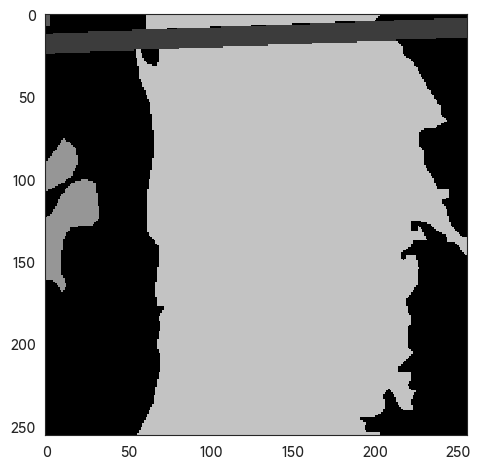

In [28]:
mask_np = io.imread(
    r"D:\IDMDownloads\ZIP\data\data_for_keras_aug\train_masks\train\GF2_PMS1__L1A0000564539-MSS1_15label_06.tif")[0]
np.unique(mask_np)
io.imshow(mask_np * 15)